In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df=pd.read_csv('CLTV.csv')

In [3]:
df.info()
#No null values noticed, 16 categorical variables, 8 numeric variables(including the dependent variable)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

In [4]:
(df.isna().sum()/7043)*100
#Clean dataset: No nulls

Customer                         0.0
State                            0.0
Customer Lifetime Value          0.0
Response                         0.0
Coverage                         0.0
Education                        0.0
Effective To Date                0.0
EmploymentStatus                 0.0
Gender                           0.0
Income                           0.0
Location Code                    0.0
Marital Status                   0.0
Monthly Premium Auto             0.0
Months Since Last Claim          0.0
Months Since Policy Inception    0.0
Number of Open Complaints        0.0
Number of Policies               0.0
Policy Type                      0.0
Policy                           0.0
Renew Offer Type                 0.0
Sales Channel                    0.0
Total Claim Amount               0.0
Vehicle Class                    0.0
Vehicle Size                     0.0
dtype: float64

In [5]:
df.describe(include = np.object).T

,count,unique,top,freq
Customer,9134,9134,KY38074,1
State,9134,5,California,3150
Response,9134,2,No,7826
Coverage,9134,3,Basic,5568
Education,9134,5,Bachelor,2748
Effective To Date,9134,59,1/10/11,195
EmploymentStatus,9134,5,Employed,5698
Gender,9134,2,F,4658
Location Code,9134,3,Suburban,5779
Marital Status,9134,3,Married,5298


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer Lifetime Value,9134.0,8004.940475,6870.967608,1898.007675,3994.251794,5780.182197,8962.167041,83325.381190
Income,9134.0,37657.380009,30379.904734,0.000000,0.000000,33889.500000,62320.000000,99981.000000
Monthly Premium Auto,9134.0,93.219291,34.407967,61.000000,68.000000,83.000000,109.000000,298.000000
Months Since Last Claim,9134.0,15.097000,10.073257,0.000000,6.000000,14.000000,23.000000,35.000000
Months Since Policy Inception,9134.0,48.064594,27.905991,0.000000,24.000000,48.000000,71.000000,99.000000
Number of Open Complaints,9134.0,0.384388,0.910384,0.000000,0.000000,0.000000,0.000000,5.000000
Number of Policies,9134.0,2.966170,2.390182,1.000000,1.000000,2.000000,4.000000,9.000000
Total Claim Amount,9134.0,434.088794,290.500092,0.099007,272.258244,383.945434,547.514839,2893.239678


It seems unusual that 'Number of policies' has entries with value >1, given that each record denotes details per person, per vehicle, auto insurance only.

We shall scrutinize this below, utilizing some domain knowledge.

In [7]:
df[['Effective To Date', 'Number of Policies', 'Months Since Policy Inception']]

,Effective To Date,Number of Policies,Months Since Policy Inception
0,2/24/11,1,5
1,1/31/11,8,42
2,2/19/11,2,38
3,1/20/11,7,65
4,2/3/11,1,44
...,...,...,...
9129,2/10/11,2,89
9130,2/12/11,1,28
9131,2/6/11,2,37
9132,2/3/11,3,3


The dataset does not mention whether a customer owns just 1 or >1 vehicles. It is not possible to have multiple policies against the same vehicle by the same insurer. The cases where the Number of poilicies are >1, hence implies that the customer owns >1 vehicle (no data to show this) or, they may have re-purchased a policy multiple times in the same year, for some reason.

For eg. if a person who has a 6-month long policy repurchases it once it's over, it will show up as him having 2 policies for the same vehicle in that year. The same can happen if a person buys a new policy after the old one relapses/gets cancelled due to non-payment. Auto-insurance policies are ususally for either 6 months or 1 year. Occasionally it could be month-to-month.

In light of the above, the following information is needed, but missing: 
- Has the current policy been continuos since inception? 
- Does the customer use 6-month or 1-year policy?
- Were there payment gaps or periods of policy relapse since the inception (i.e. do the 'Months Since Policy inception' also include months where the customer was not actively submitted into a policy)?
- Does the customer have >1 vehicles insured with us?

Let us scrutinize the above 3 columns more to see if extra information can be extracted that can make our modeling more meaningful.

In [8]:
print("Unique months: ", pd.to_datetime(df['Effective To Date']).dt.month.unique())
print("Unique Years: ", pd.to_datetime(df['Effective To Date']).dt.year.unique())
print("Unique no. of days: ", pd.to_datetime(df['Effective To Date']).dt.day.nunique())

#for the given dataset, policies run only into January or February 2011.

Unique months:  [2 1]
Unique Years:  [2011]
Unique no. of days:  31


In [9]:
df[df['Number of Policies']==1][['Months Since Policy Inception', 'Number of Policies']]

,Months Since Policy Inception,Number of Policies
0,5,1
4,44,1
16,7,1
17,59,1
20,21,1
...,...,...
9120,69,1
9121,35,1
9128,58,1
9130,28,1


It is unusual to note that there are durations over 2 or 3 years even when the number of policies is just 1. 
I would have expected the months of inception to be <=12 months if number of policies=1

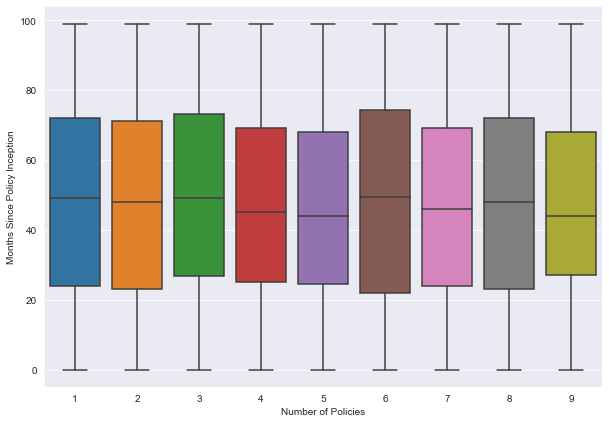

In [10]:
sns.set_style('darkgrid')
plt.figure(figsize=(10,7))   
sns.boxplot('Number of Policies', 'Months Since Policy Inception', data=df)

No trend to be observed between Number of policies and Months Since policy inception. This definitely indicates missing variables or information. We shall finalize on how to handle this scenario during modeling, after EDA

# Exploratory Data Analysis 

## Univariate analysis:

In [11]:
%%javascript
    IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

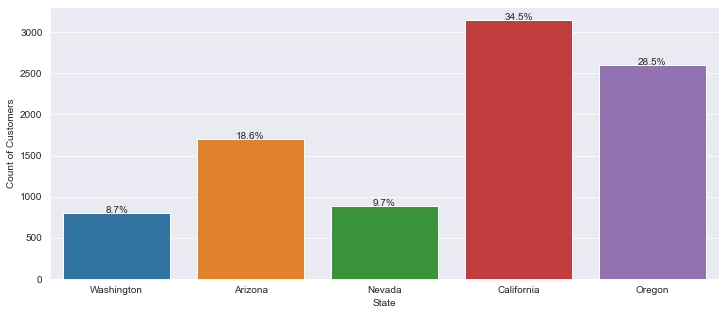

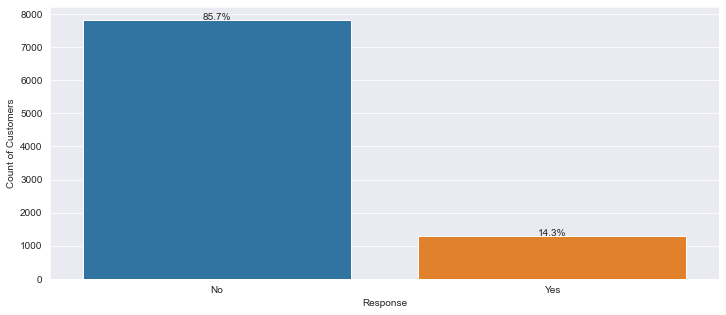

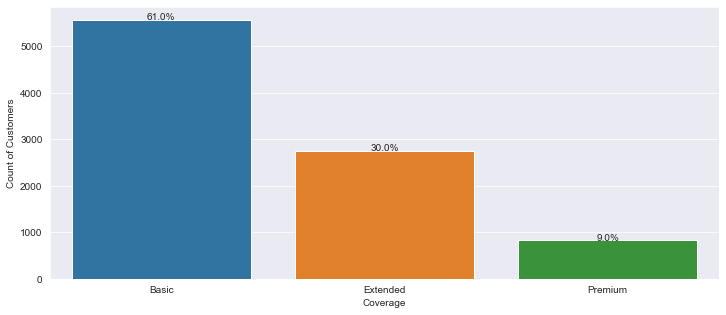

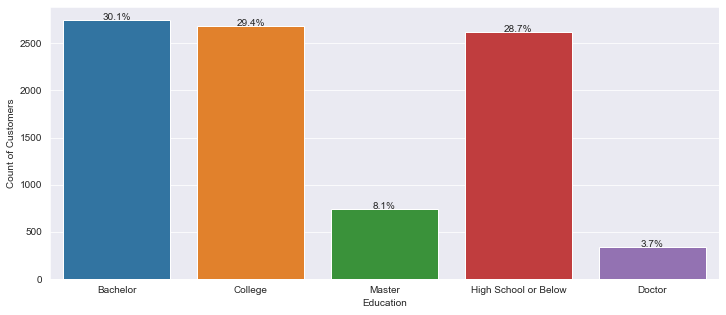

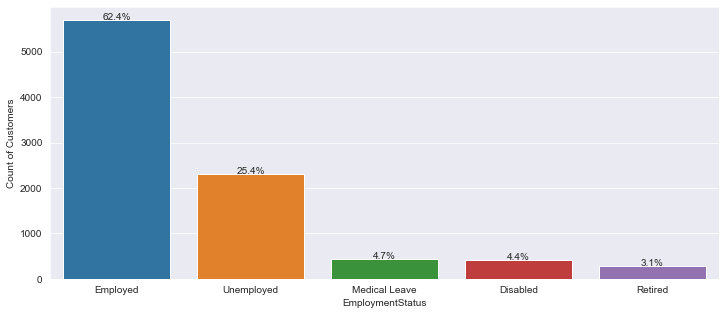

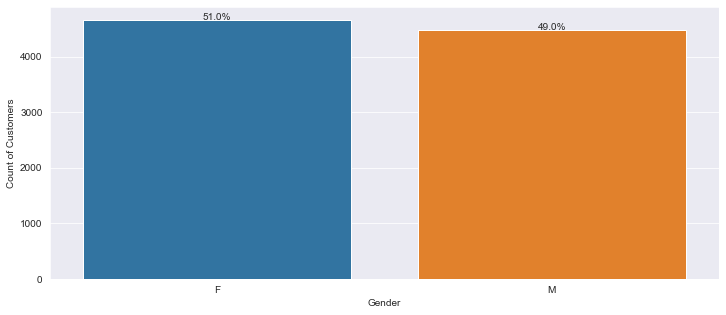

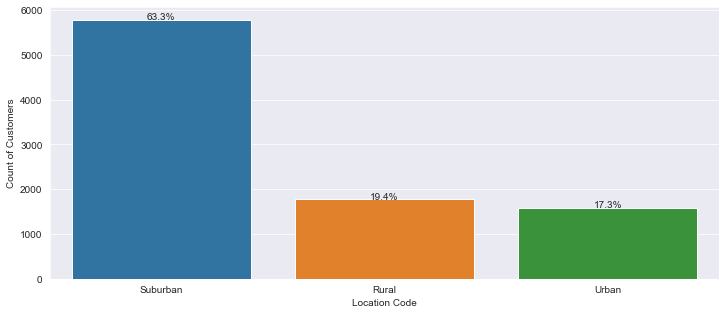

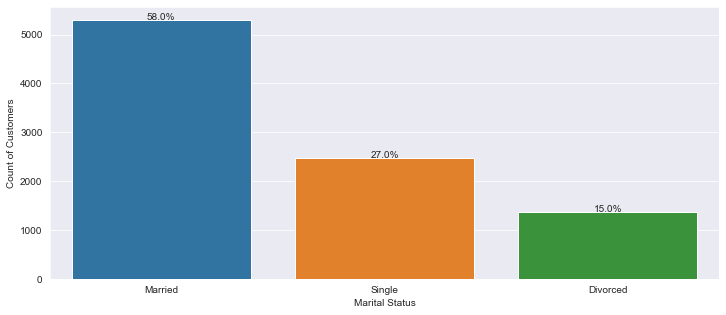

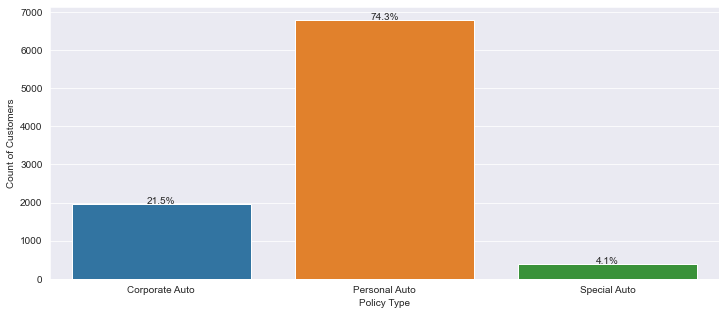

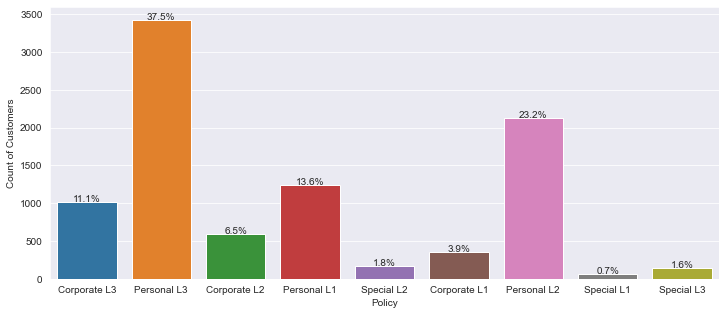

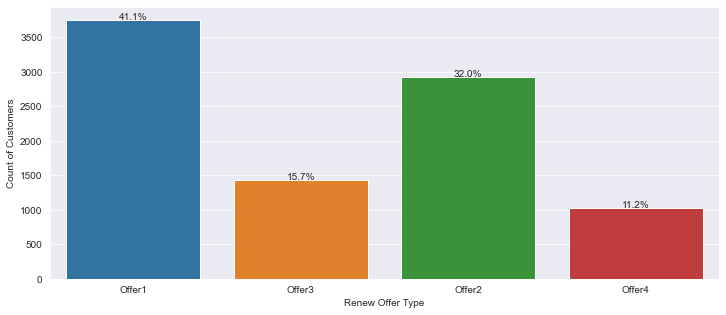

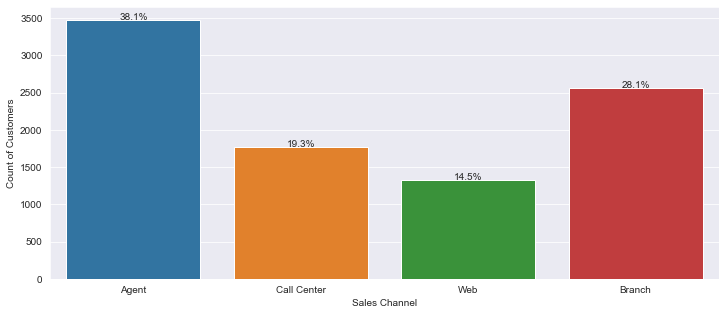

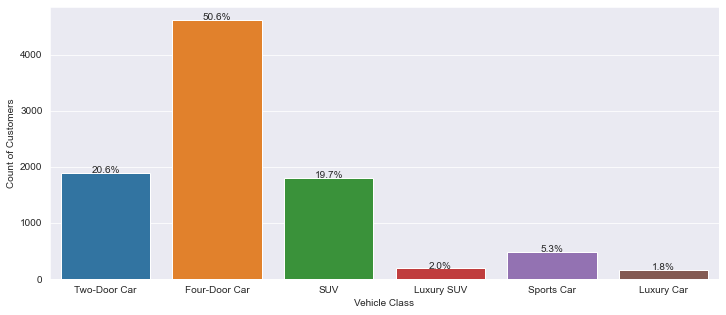

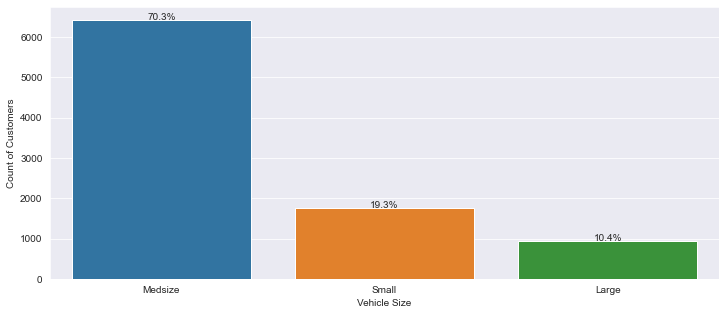

In [12]:
sns.set_style('darkgrid')
def annot(ax, total=len(df)):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2., height + 3, '{:1.1f}%'.format(height*100/total), ha="center")
for i in df.describe(include = np.object).columns.drop(['Customer', 'Effective To Date']):
    plt.figure(figsize=(12,5))
    ax=sns.countplot(x=i, data=df)
    ax.set(ylabel="Count of Customers")
    annot(ax)
plt.show()

Key Observations:

1. The dataset has customers from 5 states- majority are from California, followed by Oregon
2. 85.7% have given 'No' response to marketing communications/new Offers.
3. More than half the customers have opted for the Basic auto-insurance.
4. Those with High School & Below, Bachelor's or College education, constitute majority of the insurance takers. The numbers drop drastically as they enter Master's or Doctorate. This is a bit unexpected. It is possible that the given insurance brand may not be having attractive offers for higher education students, and hence fails to attracts those segments. 
5. As expected, majority of the insurance-takers are 'Employed'. 
6. Most customers are from the Suburban region. Personal auto-insurance is the most purchased (Personal L3)
7. Majority customers are obtained by agents and possess 4-ddor, medium size vehicles.

We will rebucket the 'Education' and 'EmploymentStatus' variable & perform bivariate analysis on select variables against Customer lifetime values, Income, Monthly premium auto, and Total Claim amount, as appropriate.

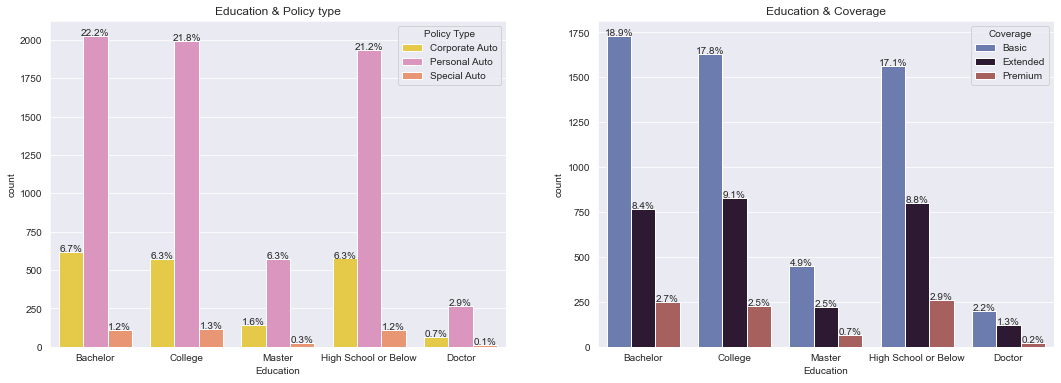

In [13]:
# sns.countplot(x='Education', hue='Coverage', data=df)
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax=sns.countplot(x='Education', hue='Policy Type', data=df, palette='Set2_r')
ax.set(title='Education & Policy type')
annot(ax)
plt.subplot(1,2,2)
ax=sns.countplot(x='Education', hue='Coverage', data=df, palette='twilight')
ax.set(title='Education & Coverage')
annot(ax)

#No unusual trends observed. The dominance of 'Personal auto' as the most purchased insurance
# and 'Basic' as the most preferred Coverage type, can be seen across the education categories.

In [14]:
#Re-bucketing Education
def change(x):
    if x in ['Bachelor', 'College', 'High School or Below']:
        return 'Bachelor or Below'
    else:
        return x
df['Education']=df['Education'].apply(change)

In [15]:
#Re-bucketing Employment Status
def func(y):
    if y in ['Medical Leave', 'Disabled', 'Retired']:
        return 'Retired_Others'
    else:
        return y
df['EmploymentStatus']=df['EmploymentStatus'].apply(func)

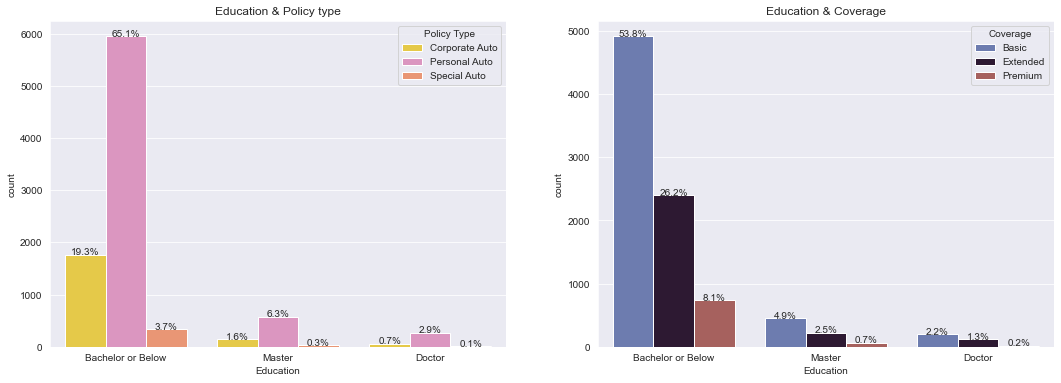

In [16]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
ax=sns.countplot(x='Education', hue='Policy Type', data=df, palette='Set2_r')
ax.set(title='Education & Policy type')
annot(ax)
plt.subplot(1,2,2)
ax=sns.countplot(x='Education', hue='Coverage', data=df, palette='twilight')
ax.set(title='Education & Coverage')
annot(ax)

#The trends stay the same, but the re-bucketing has made the classes in 'Education' more distinct

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B5B3288E48>,
      dtype=object)

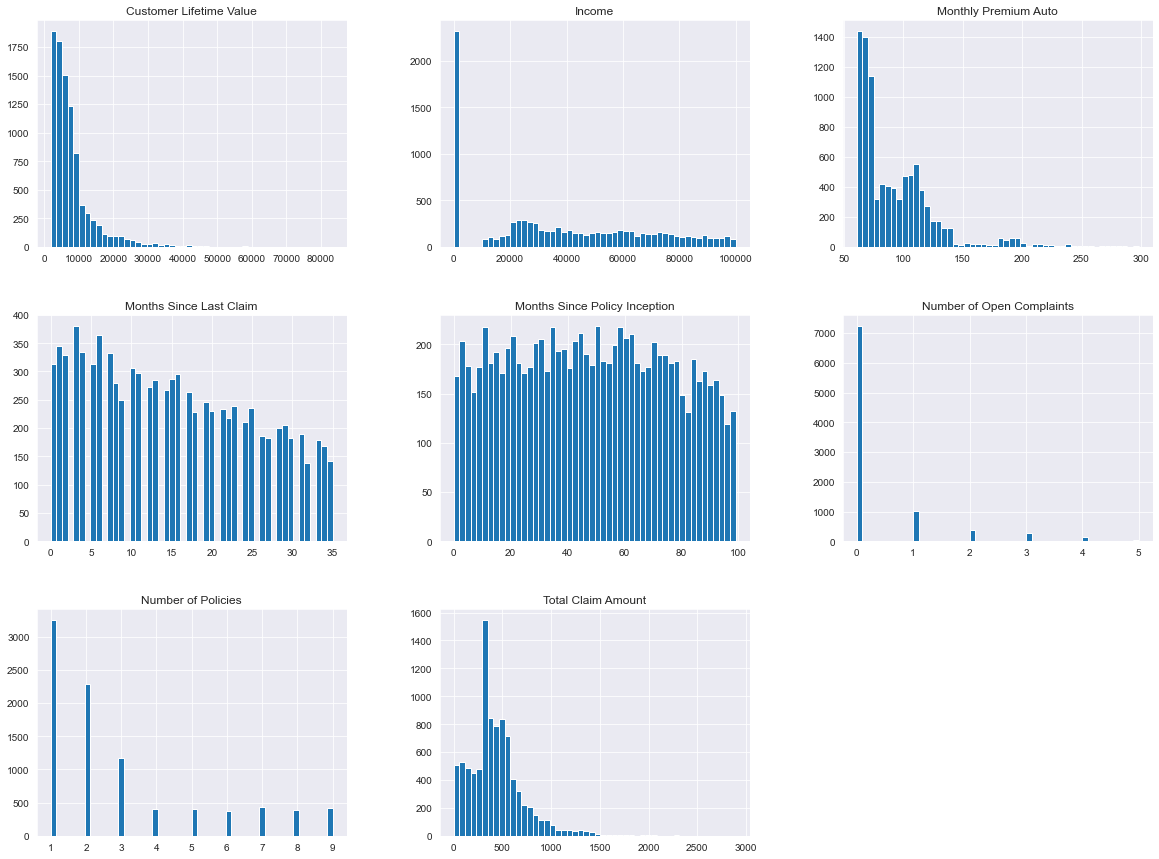

In [17]:
df.hist(bins=50, figsize=(20,15))
#Customer Lifetime Value is right skewed. So is Monthly premium auto

## Bivariate Analysis

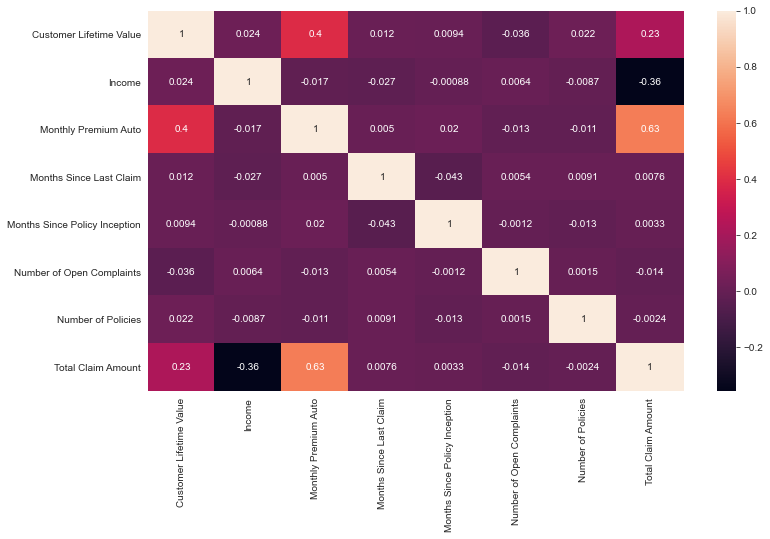

In [49]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(), cbar=True, annot=True)

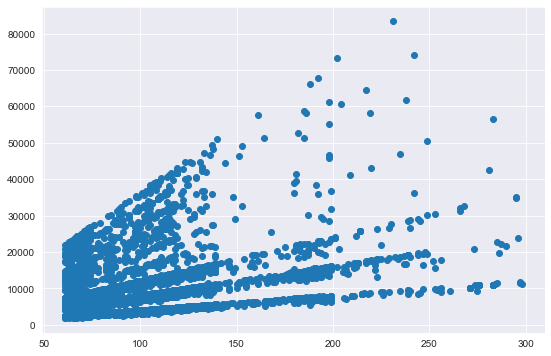

In [18]:
#Monthly premium auto Vs Customer Lifetime Value
plt.figure(figsize=(9,6))
plt.scatter(df['Monthly Premium Auto'], df['Customer Lifetime Value'])

Customer Lifetime is definitely increasing as a person pays more monthly premium auto. This probably indicates brand loyalty, customer satisfaction etc. 

There appears to exist underlying classes in the above plot. We shall examine the same below:

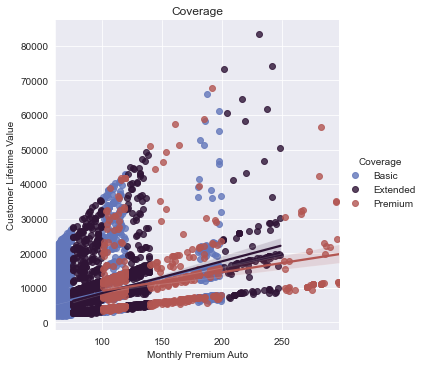

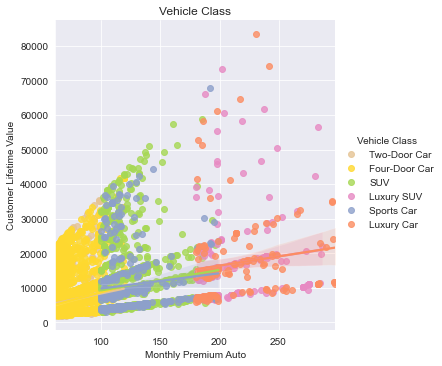

In [19]:
plt.figure(figsize=(17,5))
plt.subplot(1,2,1)
plt.close()
ax=sns.lmplot('Monthly Premium Auto', 'Customer Lifetime Value', hue='Coverage', palette='twilight',data=df)
ax.set(title="Coverage")
plt.show()
plt.subplot(1,2,2)
plt.close()
ax=sns.lmplot('Monthly Premium Auto', 'Customer Lifetime Value', hue='Vehicle Class', palette='Set2_r',data=df)
ax.set(title="Vehicle Class")
plt.show()

A certain trend in Customer Lifetime value is observed when Coverage is considered. 'Basic' is opted more by those that pay monthly auto premium in the smaller brackets, and gets more dispersed as we move ahead in the monthly auto premium. A certain hierarchy seems to be loosely followed by the 3 coverage categories.

The divide is more obvious when Vehicle Class is considered. The number of Sports car or luxury car owners in the lower monthly-auto-premium range (<$100) is almost none. Luxury car owners almost always opt for more monthly premium than sports car owners and have more Customer Lifetime values.

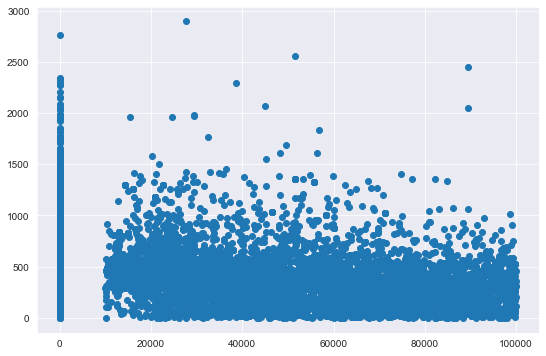

In [20]:
#Income Vs Total Claim Amount
plt.figure(figsize=(9,6))
plt.scatter(df['Income'], df['Total Claim Amount'])
#No noticeable trend

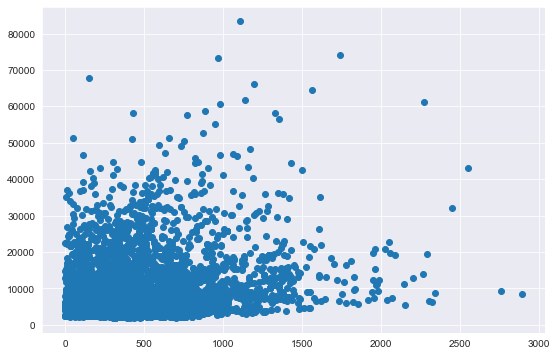

In [112]:
#Total Claim Amount vs Customer Lifetime Value
plt.figure(figsize=(9,6))
plt.scatter(df['Total Claim Amount'], df['Customer Lifetime Value'])
#An overall or rough positive relationship oobserved.

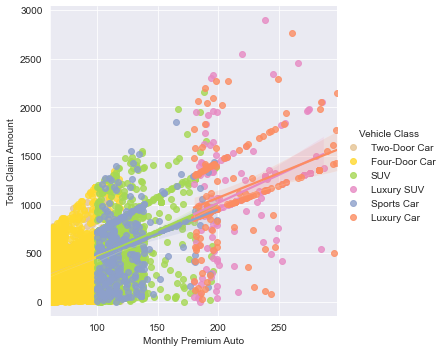

In [21]:
#Monthly premium auto vs Total claim amount
sns.lmplot('Monthly Premium Auto', 'Total Claim Amount', hue='Vehicle Class', palette='Set2_r',data=df)
#Fairly strong positive relationship observed. Divide between different vehicle sizes evident.

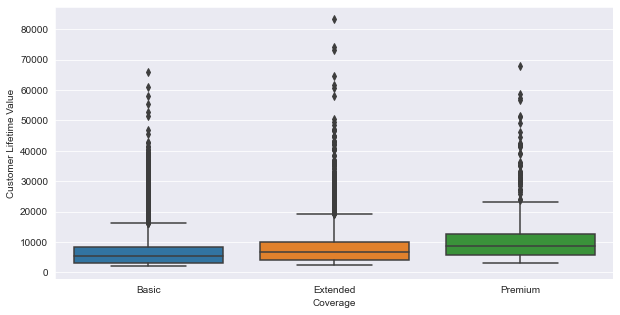

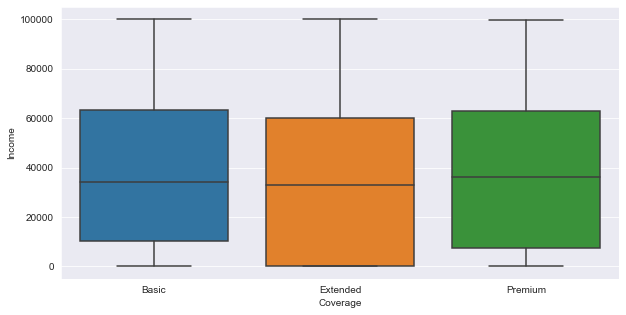

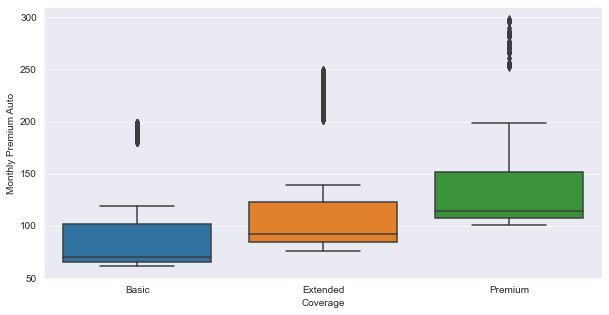

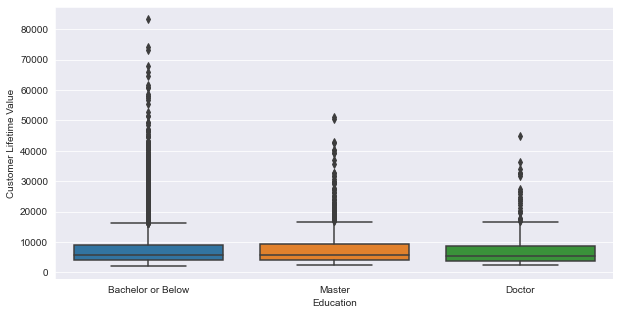

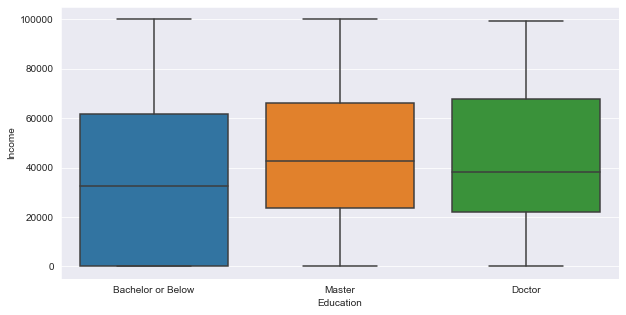

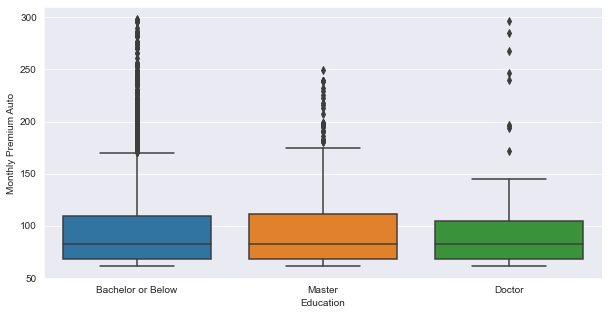

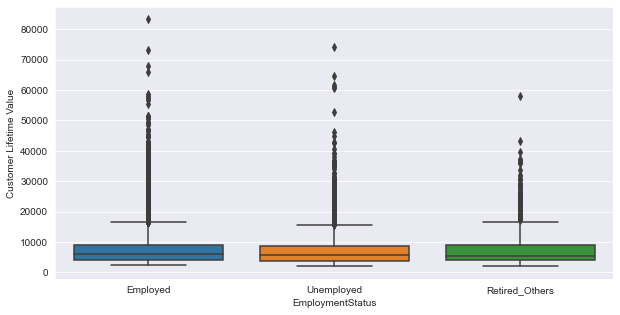

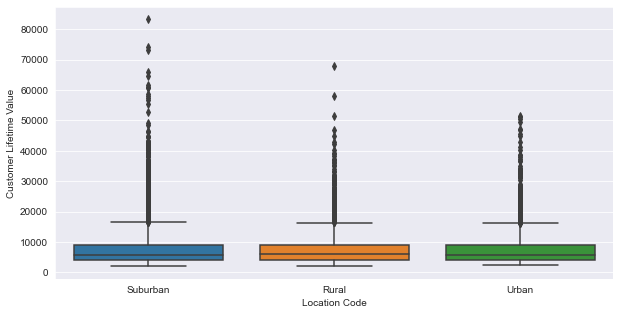

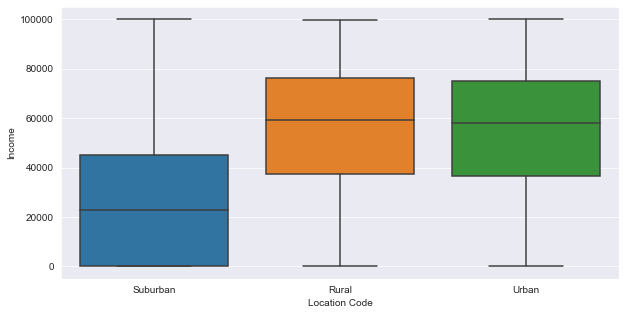

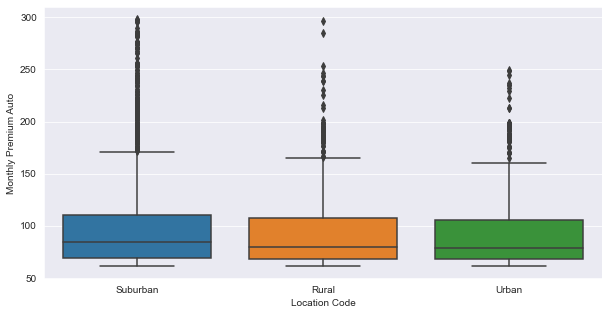

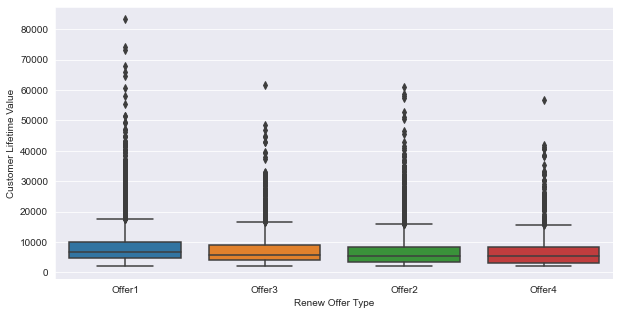

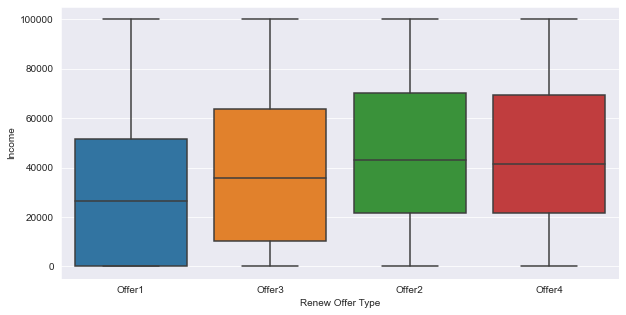

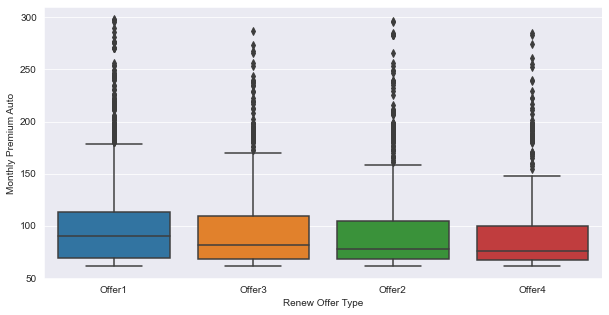

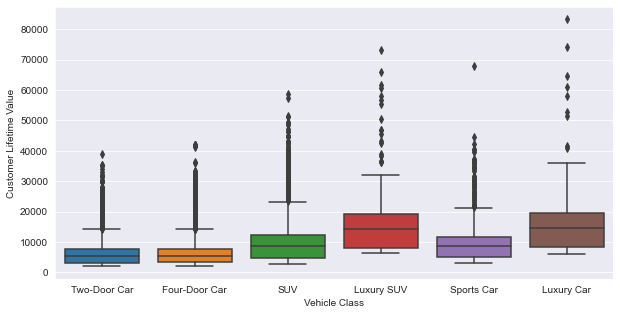

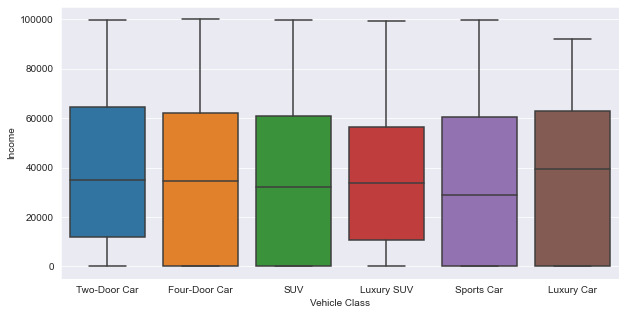

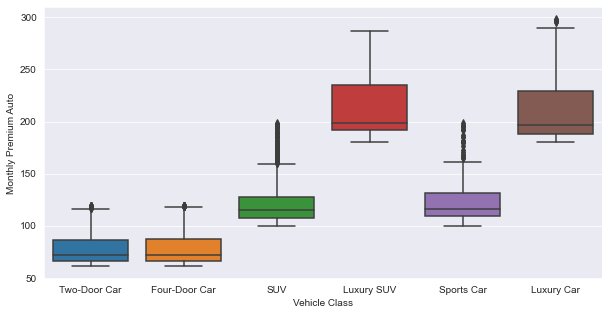

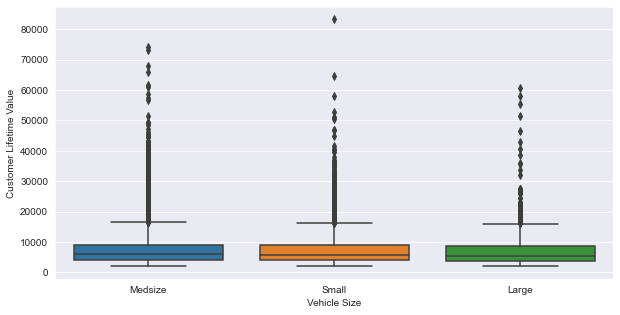

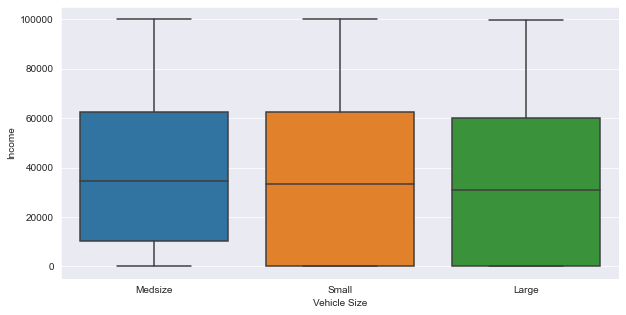

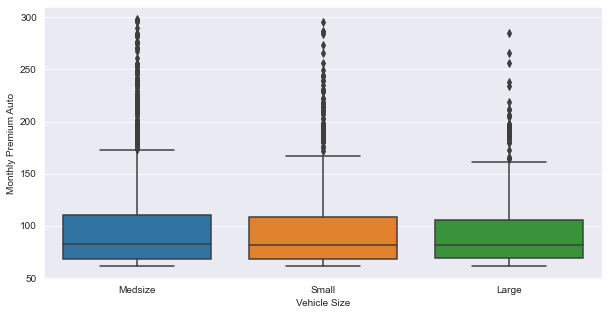

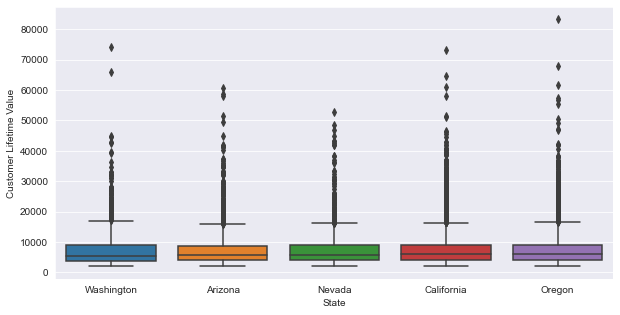

In [22]:
# Box-plots

sns.set_style('darkgrid')
def box(x, y):
    plt.figure(figsize=(10,5))   
    ax = sns.boxplot(x, y, data=df)
    ax.set_xticklabels(ax.get_xticklabels())

box('Coverage', 'Customer Lifetime Value')
box('Coverage', 'Income')
box('Coverage', 'Monthly Premium Auto')

box('Education', 'Customer Lifetime Value')
box('Education', 'Income')
box('Education', 'Monthly Premium Auto')

box('EmploymentStatus', 'Customer Lifetime Value')

box('Location Code', 'Customer Lifetime Value')
box('Location Code', 'Income')
box('Location Code', 'Monthly Premium Auto')

box('Renew Offer Type', 'Customer Lifetime Value')
box('Renew Offer Type', 'Income')
box('Renew Offer Type', 'Monthly Premium Auto')

box('Vehicle Class', 'Customer Lifetime Value')
box('Vehicle Class', 'Income')
box('Vehicle Class', 'Monthly Premium Auto')

box('Vehicle Size', 'Customer Lifetime Value')
box('Vehicle Size', 'Income')
box('Vehicle Size', 'Monthly Premium Auto')

box('State', 'Customer Lifetime Value')
#Varuables I feel need not be included for predictive modeling: Education, Policy type, sales channel, vehicle size

1. Mean Customer Lifetime Value shifts slightly as Coverage type changes, and Coverage definitely influences Monthly auto premium. But it has very minimal association with Income. Hence, income is not a prominent factor based on which a person decides the type of coverage they want. 
2. Education has no visible impact on mean Customer Lifetime Value and no significant association with Income or Monthly auto premium being charged to the customer. But there is considerable variability in Customer Lifetime Value within each Education category.
3. Employment status, Location code and Renew Offer Type too shows minimal change across categories for their mean Customer Lifetime Values, but there is ample variation within categories.
4. mean Customer Lifetime value shows considerable shifts as per vehicle class, with the Luxury categories displaying visibly more Lifetime values.
5. The state a person belongs to seems to have no visible impact on lifetime.

We shall run the regression model and retain those variables that show significance.

# Predictive Modeling: 

In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from scipy import stats

In [24]:
AIC=[]
error_skew=[]

In [25]:
#We are removing irrelevant variables.
df.drop(['Customer', 'Effective To Date', 'Gender', 'Response'], axis=1, inplace=True)

## Encoding Categorical features- Linear Regression- Model Evaluation: 

In [26]:
def visual(y_test, pred):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.scatter(y_test, pred, c='red')
    plt.subplot(1,2,2)
    sns.distplot(y_test-pred)
    plt.xlabel('errors')
    print("MAE: ", round(metrics.mean_absolute_error(y_test, pred), 4), "\nMSE: ", 
      round(metrics.mean_squared_error(y_test, pred), 4), "\nRMSE: ", 
      round(np.sqrt(metrics.mean_squared_error(y_test, pred)), 4))  
    print("Skewness of error distribution: ", (y_test-pred).skew())
    error_skew.append((y_test-pred).skew())
    
def linreg(x_train, x_test, y_train, y_test):
    x2 = sm.add_constant(x_train)
    est = sm.OLS(y_train, x2)
    est2 = est.fit()
    AIC.append(est2.aic)
    print(est2.summary())
    print("\nAIC: ", est2.aic)
    
    lm=LinearRegression()
    lm.fit(x_train, y_train)
    print("\nintercept: ", lm.intercept_, "\n", "R^2: ", lm.score(x_train, y_train))
    pred=lm.predict(x_test)
    visual(y_test, pred)

def catencode(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)
    cat_x_train=x_train.loc[:, df.dtypes == np.object]
    ohe=OneHotEncoder(drop='first', sparse=False)
    x_train2=ohe.fit_transform(cat_x_train)
    x_train2=pd.DataFrame(x_train2, index=x_train.index, columns=ohe.get_feature_names(cat_x_train.columns))
    x_train=pd.concat([x_train, x_train2], axis=1)
    x_train.drop(cat_x_train.columns, axis=1, inplace=True)

    x_test2=ohe.transform(x_test[cat_x_train.columns])
    x_test2=pd.DataFrame(x_test2, index=x_test.index, columns=ohe.get_feature_names(cat_x_train.columns))
    x_test=pd.concat([x_test, x_test2], axis=1)
    x_test.drop(cat_x_train.columns, axis=1, inplace=True)
    return x_train, x_test, y_train, y_test

### Linear Regression Model 1: 

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.178
Model:                                 OLS   Adj. R-squared:                  0.173
Method:                      Least Squares   F-statistic:                     32.85
Date:                     Mon, 17 Aug 2020   Prob (F-statistic):          4.46e-235
Time:                             02:08:10   Log-Likelihood:                -65001.
No. Observations:                     6393   AIC:                         1.301e+05
Df Residuals:                         6350   BIC:                         1.304e+05
Df Model:                               42                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

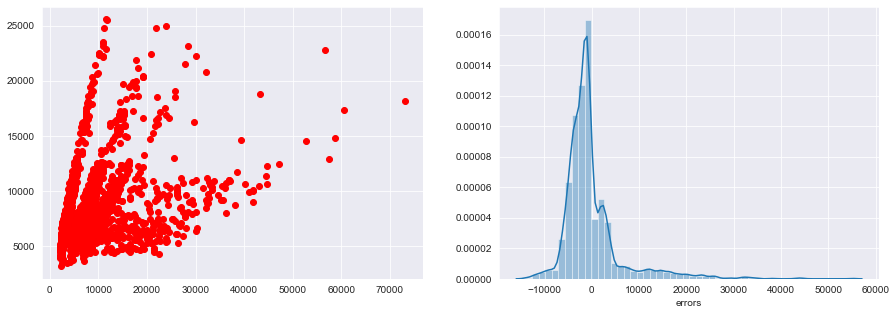

In [27]:
# x=df.drop(['Customer Lifetime Value', 'Number of Policies', 'Months Since Policy Inception'], axis=1)
x=df.drop('Customer Lifetime Value', axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

The error distribution is highly skewed, indicating that the model needs to be much better.

### Hypothesis Testing: 

- Null H0: None of the regressors are significant to explain changes in the Customer Lifetime Value
- Alternate H1: Atleast 1 of the independednt variables will be significant and able to explain Customer Lifetime Value

The Joint Hypothesis Test described above uses the p-vale asscoiated with the F-statistic: 3.77e-236

p(F-stat) is <0.05, i.e. it's < than 5%. Hence Null H0 rejected. 

Conclusion: Atleast one of the regressors ARE significant and can explain the dependent variable.

However R^2 is just 17.8%, i.e. model is able to explain the target variable only upto 17.8%, which is very less.

### Linear Regression Model 2:

Dropped insignificant variables to re-run the model:

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.175
Model:                                 OLS   Adj. R-squared:                  0.173
Method:                      Least Squares   F-statistic:                     90.02
Date:                     Mon, 17 Aug 2020   Prob (F-statistic):          4.27e-252
Time:                             02:08:24   Log-Likelihood:                -65016.
No. Observations:                     6393   AIC:                         1.301e+05
Df Residuals:                         6377   BIC:                         1.302e+05
Df Model:                               15                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

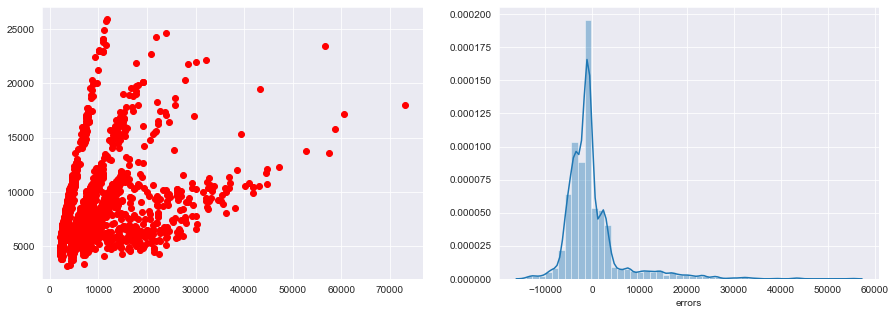

In [28]:
x=df[['Monthly Premium Auto', 'Number of Open Complaints', 'EmploymentStatus', 'Policy', 'Renew Offer Type']]
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

The model shows no considerable improvement even after including only significant variables. The error distribution is still heavily skewed and R^2 is still too low.

### Linear Regression Model 3: 

We shall next consider only those records where Number of policies is 1 or 2 and Months since inception is 12 or less- as a quick check.

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.671
Model:                                 OLS   Adj. R-squared:                  0.642
Method:                      Least Squares   F-statistic:                     22.53
Date:                     Mon, 17 Aug 2020   Prob (F-statistic):           8.51e-87
Time:                             02:08:48   Log-Likelihood:                -4987.4
No. Observations:                      506   AIC:                         1.006e+04
Df Residuals:                          463   BIC:                         1.024e+04
Df Model:                               42                                         
Covariance Type:                 nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------

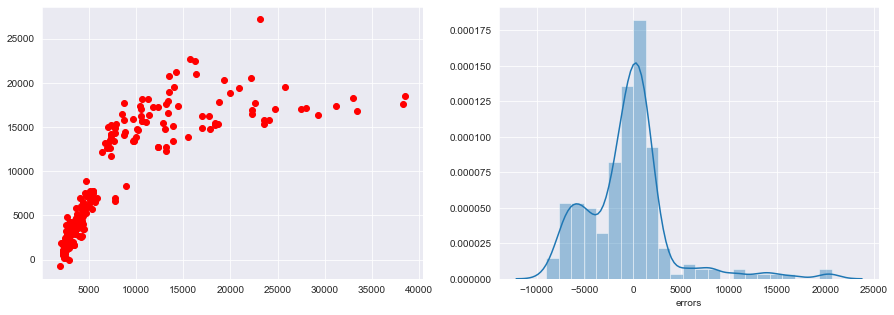

In [29]:
df1=df[(df['Number of Policies']<3) & (df['Months Since Policy Inception']<13)]
x=df1.drop('Customer Lifetime Value', axis=1)
y=df1['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

- R^2 has improved and risen to 67%
- p-value of the F-stat -although higher than the previous value- tells us that the model is significant (i.e. there is atleast one significant regressor which can explain the dependent variable)
- AIC has decreased as opposed to the previous model, which indicates a better model. 
- However, fewer regressors are significant now.

The error distribution is less skewed than before, but still highly skewed.

### Linear Regression Model 4: 

Dropped all the insignificant variables to re-run the model:

                               OLS Regression Results                              
Dep. Variable:     Customer Lifetime Value   R-squared:                       0.650
Model:                                 OLS   Adj. R-squared:                  0.646
Method:                      Least Squares   F-statistic:                     185.3
Date:                     Mon, 17 Aug 2020   Prob (F-statistic):          2.26e-111
Time:                             02:08:54   Log-Likelihood:                -5003.8
No. Observations:                      506   AIC:                         1.002e+04
Df Residuals:                          500   BIC:                         1.004e+04
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

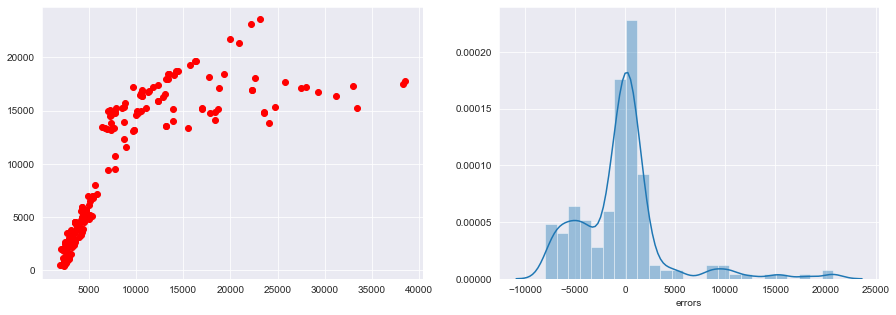

In [30]:
x=df1[['Monthly Premium Auto', 'Number of Policies', 'Renew Offer Type']]
y=df1['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

The error distribution is heavily skewed and similar to previous value. However, all the variables are significant now, model has joint significance, and AIC value is the lowest when comparing to the previous 3 models.

## Linear Regression with Log transformation (Log-linear model):

In [31]:
from math import log

In [32]:
for i in df.loc[:, (df.dtypes == np.int64) | (df.dtypes == np.float64)].columns:
    print("Skew "+i+": ", df[i].skew())

Skew Customer Lifetime Value:  3.032280259929985
Skew Income:  0.28688727581189166
Skew Monthly Premium Auto:  2.1235464499475345
Skew Months Since Last Claim:  0.2785863118107981
Skew Months Since Policy Inception:  0.040164961597799524
Skew Number of Open Complaints:  2.783263052399567
Skew Number of Policies:  1.2533327352739663
Skew Total Claim Amount:  1.7149658097209557


In [33]:
df['lnCLTV']=df['Customer Lifetime Value'].apply(lambda x:log(x))

### Linear Regression Model 5:

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     55.01
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        02:09:16   Log-Likelihood:                -5387.2
No. Observations:                6393   AIC:                         1.086e+04
Df Residuals:                    6350   BIC:                         1.115e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

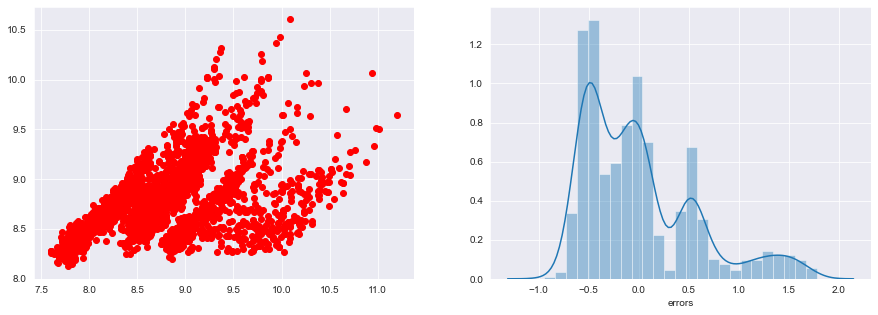

In [34]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

Let's re-run the model, after eliminating the insignificant variables.

### Linear Regression Model 6:

                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     91.87
Date:                Mon, 17 Aug 2020   Prob (F-statistic):               0.00
Time:                        02:09:30   Log-Likelihood:                -5394.6
No. Observations:                6393   AIC:                         1.084e+04
Df Residuals:                    6367   BIC:                         1.102e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

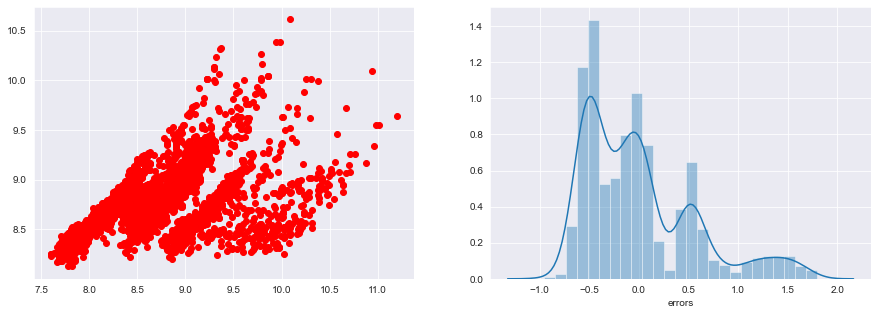

In [35]:
x=df[['Monthly Premium Auto', 'Number of Open Complaints', 'Number of Policies', 'Coverage', 'EmploymentStatus',
     'Marital Status', 'Policy', 'Renew Offer Type', 'Vehicle Class']]
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)
linreg(x_tr, x_te, y_tr, y_te)

In [36]:
print("Model with lowest AIC value: Model ", AIC.index(min(AIC))+1)
print("Model whose error distribution is closest to normality, compared to other models: Model ", 
      error_skew.index(min(error_skew))+1)

Model with lowest AIC value: Model  4
Model whose error distribution is closest to normality, compared to other models: Model  6


### Random Forest Regression Model 7:

R^2:  0.9572
                                 Coefficients
Income                               0.034539
Monthly Premium Auto                 0.249139
Months Since Last Claim              0.046733
Months Since Policy Inception        0.040099
Number of Open Complaints            0.005497
Number of Policies                   0.475520
Total Claim Amount                   0.044381
State_California                     0.003299
State_Nevada                         0.003232
State_Oregon                         0.003767
State_Washington                     0.003566
Coverage_Extended                    0.002062
Coverage_Premium                     0.003112
Education_Doctor                     0.001940
Education_Master                     0.002711
EmploymentStatus_Retired_Others      0.002382
EmploymentStatus_Unemployed          0.002535
Location Code_Suburban               0.001426
Location Code_Urban                  0.003173
Marital Status_Married               0.004362
Marital Status_Single

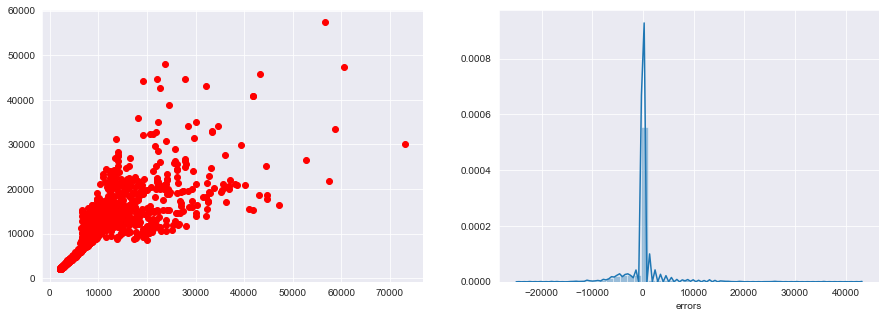

In [38]:
from sklearn.ensemble import RandomForestRegressor
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['Customer Lifetime Value']
x_tr, x_te, y_tr, y_te = catencode(x, y)

rfr=RandomForestRegressor()
rfr.fit(x_tr, y_tr)
print("R^2: ", round(rfr.score(x_tr, y_tr), 4))
coefs=pd.DataFrame(rfr.feature_importances_, x_tr.columns, columns=['Coefficients'])
print(coefs)
pred=rfr.predict(x_te)
print("\n")
visual(y_te, pred)

# rfr.feature_importances_

### Random Forest Regression Model 8:

R^2:  0.9866
                                 Coefficients
Income                               0.014871
Monthly Premium Auto                 0.219108
Months Since Last Claim              0.013801
Months Since Policy Inception        0.013570
Number of Open Complaints            0.003236
Number of Policies                   0.685270
Total Claim Amount                   0.013700
State_California                     0.001274
State_Nevada                         0.001252
State_Oregon                         0.001345
State_Washington                     0.000845
Coverage_Extended                    0.002830
Coverage_Premium                     0.000824
Education_Doctor                     0.000671
Education_Master                     0.001037
EmploymentStatus_Retired_Others      0.001146
EmploymentStatus_Unemployed          0.001008
Location Code_Suburban               0.000515
Location Code_Urban                  0.000869
Marital Status_Married               0.001724
Marital Status_Single

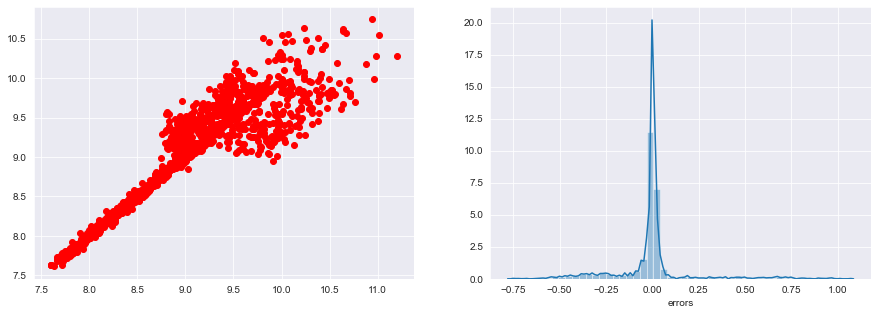

In [39]:
x=df.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df['lnCLTV']
x_tr, x_te, y_tr, y_te = catencode(x, y)

rfr=RandomForestRegressor()
rfr.fit(x_tr, y_tr)
print("R^2: ", round(rfr.score(x_tr, y_tr), 4))
coefs=pd.DataFrame(rfr.feature_importances_, x_tr.columns, columns=['Coefficients'])
print(coefs)
pred=rfr.predict(x_te)
print("\n")
visual(y_te, pred)

Repeat the above steps for only select records as shown below. Implement k-fold cross validation as amount of data is very less once we pick out these records.

In [228]:
df1=df[(df['Number of Policies']<3) & (df['Months Since Policy Inception']<13)]

In [236]:
df1['lnCLTV']=df1['Customer Lifetime Value'].apply(lambda x:log(log(x)))

C:\Users\Roshiny Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [237]:
for i in df1.loc[:, (df.dtypes == np.int64) | (df.dtypes == np.float64)].columns:
    print("Skew "+i+": ", df1[i].skew())

Skew Customer Lifetime Value:  1.7083136862893864
Skew Income:  0.2882376907138584
Skew Monthly Premium Auto:  1.596895096202826
Skew Months Since Last Claim:  0.20806769611798526
Skew Months Since Policy Inception:  0.014928030583812675
Skew Number of Open Complaints:  2.625650281474652
Skew Number of Policies:  0.3926333831471329
Skew Total Claim Amount:  1.082119658643657
Skew lnCLTV:  0.4779061502649802


In [239]:
# df1.drop(['Customer', 'Effective To Date', 'Gender', 'Response'], axis=1, inplace=True)
x=df1.drop(['Customer Lifetime Value', 'lnCLTV'], axis=1)
y=df1['lnCLTV']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

cat_x_train=x_train.loc[:, df.dtypes == np.object]
ohe=OneHotEncoder(drop='first', sparse=False)
x_train2=ohe.fit_transform(cat_x_train)
x_train2=pd.DataFrame(x_train2, index=x_train.index, columns=ohe.get_feature_names(cat_x_train.columns))
x_train=pd.concat([x_train, x_train2], axis=1)
x_train.drop(cat_x_train.columns, axis=1, inplace=True)

x_test2=ohe.transform(x_test[cat_x_train.columns])
x_test2=pd.DataFrame(x_test2, index=x_test.index, columns=ohe.get_feature_names(cat_x_train.columns))
x_test=pd.concat([x_test, x_test2], axis=1)
x_test.drop(cat_x_train.columns, axis=1, inplace=True)

print(x_train.shape)
print(x_test.shape)

(506, 44)
(217, 44)


                            OLS Regression Results                            
Dep. Variable:                 lnCLTV   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     114.3
Date:                Sun, 16 Aug 2020   Prob (F-statistic):          1.33e-216
Time:                        18:00:59   Log-Likelihood:                 1102.4
No. Observations:                 506   AIC:                            -2119.
Df Residuals:                     463   BIC:                            -1937.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

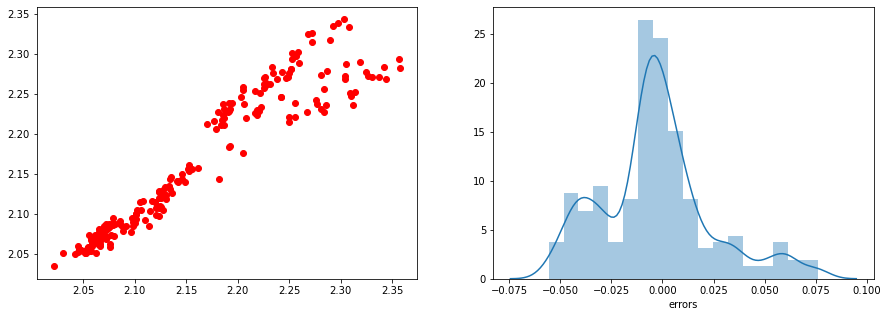

In [240]:
x2 = sm.add_constant(x_train)
est = sm.OLS(y_train, x2)
est2 = est.fit()
print(est2.summary())

lm=LinearRegression()
lm.fit(x_train, y_train)
print("intercept: ", lm.intercept_, "\n", "R^2: ", lm.score(x_train, y_train))
coefs=pd.DataFrame(lm.coef_, x_train.columns, columns=['Coefficients'])
coefs
pred=lm.predict(x_test)
# print(pd.DataFrame(pred, y_test.index, columns=['overall_rating_predicted']).head())
# print(pd.DataFrame(y_test).head())

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(y_test, pred, c='red')
plt.subplot(1,2,2)
sns.distplot(y_test-pred)
plt.xlabel('errors')

print("MAE: ", round(metrics.mean_absolute_error(y_test, pred), 4), "\nMSE: ", round(metrics.mean_squared_error(y_test, pred), 4), "\nRMSE: ", round(np.sqrt(metrics.mean_squared_error(y_test, pred)), 4))
print("Skew: ", (y_test-pred).skew())